In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

# 2. EDA & 전처리

### education

In [5]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [6]:
df = pd.concat([train, test])

df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

num = 7
train['age_group'] = pd.qcut(train.age, num)
test['age_group'] = pd.qcut(test.age, num)

train['fnlwgt_group'] = pd.qcut(train.fnlwgt, num)
test['fnlwgt_group'] = pd.qcut(test.fnlwgt, num)

train['Priority'] = 0


train.loc[((train['occupation'] == 'Exec-managerial')&(train['workclass'] == 'Self-emp-inc')), 'Priority'] = 8

train.loc[((train['workclass'] == 'Federal-gov')*(train['occupation'] == 'Prof-specialty')), 'Priority'] = 7

train.loc[  ((train['workclass'] == 'Local-gov') | (train['workclass'] == 'Self-emp-not-inc'))
          & ((train['occupation'] == 'Protective-serv') | (train['occupation'] == 'Tech-support'))
          , 'Priority'] = 6

train.loc[((train['workclass'] == 'State-govv') & (train['occupation'] == 'Sales')), 'Priority'] = 5

train.loc[(
           (train['workclass'] == 'Private') & ((train['occupation'] == 'Craft-repair')
                                                |(train['occupation'] == 'Transport-moving'))
           ), 'Priority'] = 4

train.loc[((train['occupation'] == 'Adm-clerical') 
           | (train['occupation'] == 'Machine-op-inspct') 
           | (train['occupation'] == 'Farming-fishing')), 'Priority'] = 3

train.loc[((train['workclass'] == '?') & (train['occupation'] == '?')), 'Priority'] = 2
train.loc[((train['occupation'] == 'Handlers-cleaners') 
           | (train['occupation'] == 'Other-service') 
           | (train['occupation'] == 'Priv-house-serv')), 'Priority'] = 1
train.loc[(
    ((train['workclass'] == 'Never-worked')
    | (train['workclass'] == 'Without-pay'))
    & (train['occupation'] == 'Armed-Forces')), 'Priority'] = 0

test['Priority'] = 0


test.loc[((test['occupation'] == 'Exec-managerial')&(test['workclass'] == 'Self-emp-inc')), 'Priority'] = 8

test.loc[((test['workclass'] == 'Federal-gov')*(test['occupation'] == 'Prof-specialty')), 'Priority'] = 7

test.loc[  ((test['workclass'] == 'Local-gov') | (test['workclass'] == 'Self-emp-not-inc'))
          & ((test['occupation'] == 'Protective-serv') | (test['occupation'] == 'Tech-support'))
          , 'Priority'] = 6

test.loc[((test['workclass'] == 'State-govv') & (test['occupation'] == 'Sales')), 'Priority'] = 5

test.loc[(
           (test['workclass'] == 'Private') & ((test['occupation'] == 'Craft-repair')
                                                |(test['occupation'] == 'Transport-moving'))
           ), 'Priority'] = 4

test.loc[((test['occupation'] == 'Adm-clerical') 
           | (test['occupation'] == 'Machine-op-inspct') 
           | (test['occupation'] == 'Farming-fishing')), 'Priority'] = 3

test.loc[((test['workclass'] == '?') & (test['occupation'] == '?')), 'Priority'] = 2
test.loc[((test['occupation'] == 'Handlers-cleaners') 
           | (test['occupation'] == 'Other-service') 
           | (test['occupation'] == 'Priv-house-serv')), 'Priority'] = 1
test.loc[(
    ((test['workclass'] == 'Never-worked')
    | (test['workclass'] == 'Without-pay'))
    & (test['occupation'] == 'Armed-Forces')), 'Priority'] = 0

In [60]:
num = 13
train['capital_gain_group'] = pd.qcut(train.capital_gain, num, duplicates='drop')
test['capital_gain_group'] = pd.qcut(test.capital_gain, num, duplicates='drop')

# 3. 모델 학습

In [61]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=['Priority','Priority2']
          , numeric_features = ['education_num']
          #, ignore_features = ['fnlwgt']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 15)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 4.04 s


In [62]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.8649,0.9217,0.6484,0.7592,0.6992,0.6128,0.6162,2.2633
1,CatBoost Classifier,0.8667,0.9239,0.6381,0.7724,0.6984,0.6139,0.6188,11.3619
2,Light Gradient Boosting Machine,0.8646,0.9206,0.6432,0.7609,0.6969,0.6105,0.6143,0.3098
3,Gradient Boosting Classifier,0.8634,0.9177,0.6099,0.7781,0.6836,0.5982,0.6055,2.5871
4,Ada Boost Classifier,0.8574,0.9115,0.6180,0.7492,0.6771,0.5867,0.5913,0.7585
5,Linear Discriminant Analysis,0.8462,0.8997,0.5927,0.7225,0.6507,0.5534,0.5582,0.1949
6,Random Forest Classifier,0.8467,0.8762,0.5707,0.7373,0.6431,0.5476,0.5550,0.1243
7,Extra Trees Classifier,0.8348,0.8828,0.6008,0.6804,0.6378,0.5314,0.5333,0.5725


In [63]:
blended = blend_models(estimator_list = best_3, fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8669,0.9247,0.6149,0.7884,0.6909,0.6077,0.6153
1,0.8653,0.9206,0.6699,0.7473,0.7065,0.6194,0.6210
2,0.8669,0.9202,0.6602,0.7584,0.7059,0.6204,0.6229
3,0.8605,0.9165,0.6201,0.7579,0.6821,0.5939,0.5988
4,0.8472,0.9124,0.6019,0.7209,0.6561,0.5589,0.5626
5,0.8683,0.9339,0.6343,0.7809,0.7000,0.6168,0.6223
6,0.8832,0.9390,0.6634,0.8200,0.7335,0.6598,0.6658
7,0.8683,0.9253,0.6311,0.7831,0.6989,0.6159,0.6218
8,0.8676,0.9277,0.6311,0.7800,0.6977,0.6141,0.6197
9,0.8738,0.9234,0.6764,0.7741,0.7219,0.6408,0.6433


In [64]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8746,0.9282,0.6647,0.7843,0.7195,0.6395,0.6431


In [65]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 17s


In [66]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [67]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [68]:
submission.to_csv('output/20201022-4.csv')

In [69]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8716,0.9237,0.6375,0.7912,0.7061,0.6251,0.6311
1,0.8630,0.9183,0.6667,0.7410,0.7019,0.6132,0.6147
2,0.8630,0.9175,0.6570,0.7463,0.6988,0.6106,0.6126
3,0.8597,0.9152,0.6364,0.7452,0.6865,0.5969,0.6000
4,0.8417,0.9071,0.6181,0.6945,0.6541,0.5519,0.5535
5,0.8723,0.9298,0.6634,0.7765,0.7155,0.6338,0.6371
6,0.8785,0.9358,0.6570,0.8056,0.7237,0.6469,0.6524
7,0.8652,0.9249,0.6408,0.7645,0.6972,0.6114,0.6153
8,0.8613,0.9236,0.6214,0.7619,0.6845,0.5968,0.6019
9,0.8730,0.9215,0.6861,0.7653,0.7235,0.6415,0.6431


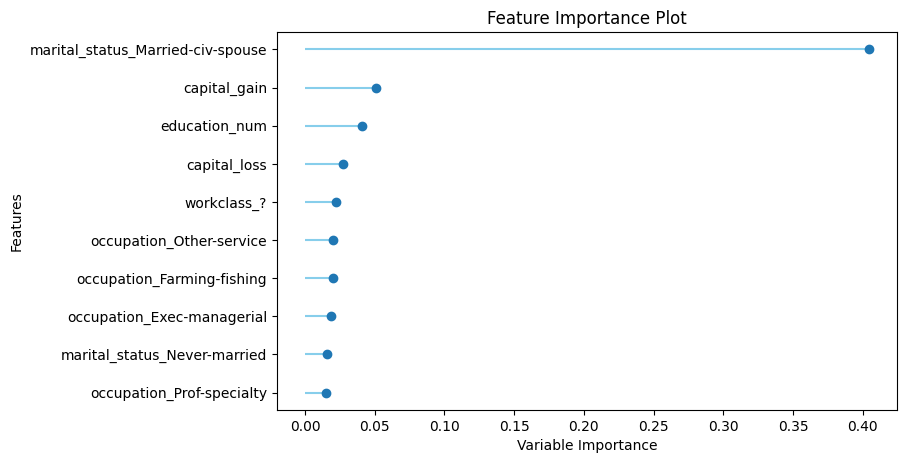

In [70]:
plot_model(estimator = xgboost, plot = 'feature')

In [71]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8630,0.9202,0.6246,0.7659,0.6881,0.6014,0.6065
1,0.8614,0.9191,0.6602,0.7391,0.6974,0.6079,0.6095
2,0.8614,0.9161,0.6602,0.7391,0.6974,0.6079,0.6095
3,0.8574,0.9120,0.6169,0.7480,0.6762,0.5858,0.5903
4,0.8503,0.9091,0.6052,0.7305,0.6619,0.5669,0.5710
5,0.8699,0.9311,0.6667,0.7658,0.7128,0.6292,0.6318
6,0.8824,0.9357,0.6634,0.8167,0.7321,0.6579,0.6637
7,0.8605,0.9196,0.6278,0.7549,0.6855,0.5969,0.6010
8,0.8715,0.9240,0.6440,0.7866,0.7082,0.6268,0.6320
9,0.8683,0.9187,0.6634,0.7621,0.7093,0.6248,0.6273


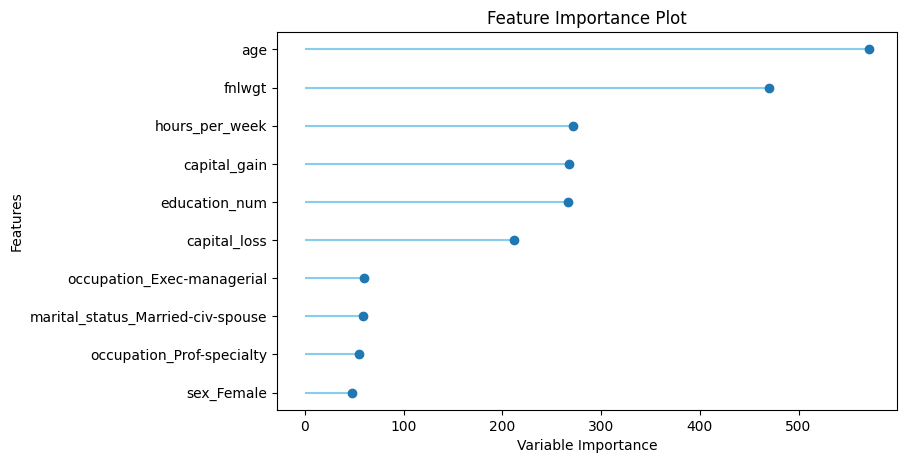

In [72]:
plot_model(estimator = lightgbm, plot = 'feature')